In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [65]:
#device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [66]:
#set up seed for consistancy
torch.manual_seed(1)
#batch_size = 64
def batchData(batch_size):
        #get MNIST dataset
    data_train = torchvision.datasets.MNIST(root='./data', 
                                               train=True, 
                                               transform=transforms.ToTensor(),  
                                               download=True)

    data_test = torchvision.datasets.MNIST(root='./data', 
                                              train=False, 
                                              transform=transforms.ToTensor(),
                                              download=True)
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                              shuffle=True)

    test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size,
                                             shuffle=False)
    
    return train_loader,test_loader

In [67]:
class CNN_1(nn.Module):
    def __init__(self):
        super(CNN_1, self).__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(1, 10, 3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(10, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(16*5*5, 20), 
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        outputs = self.convolution(x)
        return outputs

In [68]:
def getOpti(model):
    return torch.optim.SGD(model.parameters(), lr=0.001)

In [69]:
loss_func = nn.CrossEntropyLoss()

In [70]:
def testModel(model):
    n_correct = 0
    n_samples = 0
    count = 0 
    loss_per_batch = 0
    for i, (inputs, labels) in enumerate(test_loader): 
        count +=1
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = model(inputs).to(device)
        loss = loss_func(outputs, labels)
        loss_per_batch += loss.data

        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        acc = 100.0 * n_correct / n_samples
    loss_per_batch /= count
    return loss_per_batch,acc

In [71]:
def trainModel(model,num_epochs):
    n_total_steps = len(train_loader)
    loss_train = []
    epochs = []
    accuracy_train = []
    test_acc = []
    test_loss = []
    print('Training the model')
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        n_correct = 0
        n_samples = 0
        count = 0 
        loss_per_batch = 0
        for i, (inputs, labels) in enumerate(train_loader): 
            count +=1
            # get the inputs; data is a list of [inputs, labels]
            #inputs, labels = data
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer_sgd.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs).to(device)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer_sgd.step()
            loss_per_batch += loss.data
            # print statistics
            #running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples

        epochs.append(epoch)
        accuracy_train.append(acc)
        loss_per_batch /= count
        loss_train.append(loss_per_batch)
    print (f'Loss: {loss.item():.4f}, Accuracy : {acc} %')
    print('Training done')
    test_loss,test_acc=testModel(model)
    return sum(loss_train)/num_epochs,sum(accuracy_train)/num_epochs,test_loss,test_acc

In [72]:
batchSizes=[64,100,500,4000,8000]
train_acc_arr=[]
train_lss_arr=[]
test_acc_arr=[]
test_lss_arr=[]
sensitivity_arr=[]
for i in range(len(batchSizes)):
    train_loader,test_loader = batchData(batchSizes[i])
    model = CNN_1()
    optimizer_sgd = getOpti(model)
    loss_func = nn.CrossEntropyLoss()
    train_lss,train_acc,test_lss,test_acc=trainModel(model,20)
    train_acc_arr.append(train_acc)
    train_lss_arr.append(train_lss)
    test_acc_arr.append(test_acc)
    test_lss_arr.append(test_lss)
    totalNorm = 0
    counter = 0
    for p in model.parameters():
        grad = 0.0
        if p.grad is not None:
            grad = p.grad
            fNorm = torch.linalg.norm(grad).numpy()
            totalNorm += fNorm
            counter += 1
    sensitivity_arr.append(totalNorm / counter)
    

Training the model
Loss: 0.1035, Accuracy : 89.86666666666666 %
Training done
Training the model
Loss: 0.2942, Accuracy : 89.53166666666667 %
Training done
Training the model
Loss: 2.2918, Accuracy : 18.301666666666666 %
Training done
Training the model
Loss: 2.3118, Accuracy : 11.971666666666666 %
Training done
Training the model
Loss: 2.3019, Accuracy : 18.441666666666666 %
Training done


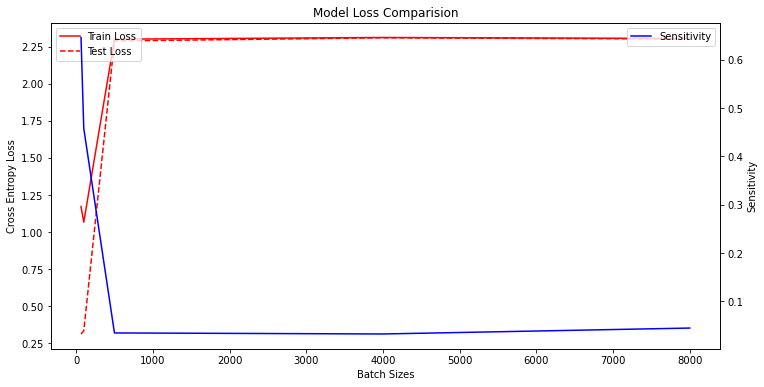

In [83]:
plt.figure(figsize=(12,6))
plt.plot(batchSizes, train_lss_arr, color = "r",label='Train Loss')
plt.plot(batchSizes, test_lss_arr, color = "r",linestyle='--',label='Test Loss')
plt.legend(loc='upper left')
plt.xlabel('Batch Sizes')
plt.ylabel('Cross Entropy Loss')
ax2 = plt.twinx()
plt.plot(batchSizes, sensitivity_arr, color = "b",label='Sensitivity')
plt.title('Model Loss Comparision')
plt.legend()
plt.xlabel('Batch Sizes')
plt.ylabel('Sensitivity')
plt.show()   

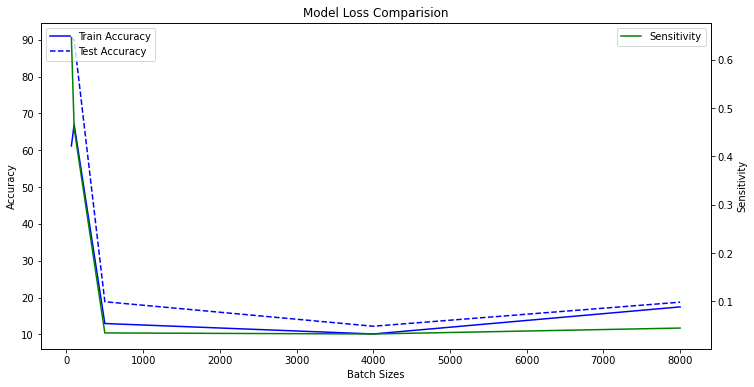

In [84]:
plt.figure(figsize=(12,6))
plt.plot(batchSizes, train_acc_arr, color = "b",label='Train Accuracy')
plt.plot(batchSizes, test_acc_arr, color = "b",linestyle='--',label='Test Accuracy')
plt.legend(loc='upper left')
plt.xlabel('Batch Sizes')
plt.ylabel('Accuracy')
ax2 = plt.twinx()
plt.plot(batchSizes, sensitivity_arr, color = "g",label='Sensitivity')
plt.title('Model Loss Comparision')
plt.legend()
plt.xlabel('Batch Sizes')
plt.ylabel('Sensitivity')
plt.show()   